<a href="https://colab.research.google.com/github/theostoican/MastersThesis/blob/main/Investigation_Escaping_local_minima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable

# Models

A dummy network that receives as input the precomputed incoming and outgoing weights and sets them directly.

In [21]:
torch.set_default_dtype(torch.float64)
class DummyNetwork(nn.Module):
  def __init__(self, D_in, H, D_out, w_in, w_out):
    """
    In the constructor we instantiate two nn.Linear modules and assign them as
    member variables.

    D_in: input dimension
    H: dimension of hidden layer
    D_out: output dimension of the first layer
    """
    super(DummyNetwork, self).__init__()
    self.linear1 = nn.Linear(D_in, H, bias=False)
    self.linear2 = nn.Linear(H, D_out, bias=False)
    self.linear1.weight = torch.nn.Parameter(w_in)
    self.linear2.weight = torch.nn.Parameter(w_out)
  def forward(self, x):
    """
    In the forward function we accept a Variable of input data and we must
    return a Variable of output data. We can use Modules defined in the
    constructor as well as arbitrary operators on Variables.
    """
    h_sigmoid = torch.sigmoid(self.linear1(x))
    y_pred = self.linear2(h_sigmoid)
    return y_pred

In [22]:
class TeacherNetwork(nn.Module):
  def __init__(self, D_in, H, D_out):
    """
    In the constructor we instantiate two nn.Linear modules and assign them as
    member variables.

    D_in: input dimension
    H: dimension of hidden layer
    D_out: output dimension of the first layer
    """
    super(TeacherNetwork, self).__init__()
    self.linear1 = nn.Linear(D_in, H, bias=False)
    self.linear2 = nn.Linear(H, D_out, bias=False)
    self.linear1.weight = torch.nn.Parameter(torch.transpose(torch.DoubleTensor([[0.6, -0.5, -0.2, 0.1], [0.5, 0.5, -0.6, -0.6]]), 0, 1))
    self.linear2.weight = torch.nn.Parameter(torch.transpose(torch.DoubleTensor([[1], [-1], [1], [-1]]), 0, 1))
  def forward(self, x):
    """
    In the forward function we accept a Variable of input data and we must
    return a Variable of output data. We can use Modules defined in the
    constructor as well as arbitrary operators on Variables.
    """
    h_sigmoid = torch.sigmoid(self.linear1(x))
    y_pred = self.linear2(h_sigmoid)
    return y_pred

# Dataset

In [23]:
D_in, H_teacher, H_student, D_out = 2, 4, 5, 1

def construct_dataset():
  data = []
  for y in np.arange(-5, 5.1, .25):
    for x in np.arange(-5, 5.1, .25):
      data.append([x, y])
  return data

dataset = torch.DoubleTensor(construct_dataset()) 
print(len(construct_dataset()))

1681


# Labels

In [24]:
teacher_model = TeacherNetwork(D_in, H_teacher, D_out)
y_labels = teacher_model(dataset).detach()

In [25]:
data = pd.read_csv('fixed_points.csv', float_precision='round_trip')

len(data)

1000

In [26]:
sample_point = data.loc[607]
sample_point['gradient_norm']

4.670743975388682e-10

### Helper for extracting the weights from one data point.

In [27]:
def extract_weights(data_point):
  incoming_weights_x = [data_point['w11'],
                      data_point['w21'],
                      data_point['w31'],
                      data_point['w41'],
                      data_point['w51']]
  incoming_weights_y = [data_point['w12'],
                      data_point['w22'],
                      data_point['w32'],
                      data_point['w42'],
                      data_point['w52']]
  outgoing_weights = [data_point['a1'],
                    data_point['a2'],
                    data_point['a3'],
                    data_point['a4'],
                    data_point['a5']]
  return incoming_weights_x, incoming_weights_y, outgoing_weights

In [28]:
incoming_weights_x, incoming_weights_y, outgoing_weights = extract_weights(sample_point)
print(incoming_weights_x)
print(incoming_weights_y)
print(outgoing_weights)

[-0.721622376427556, 0.009981938316047396, -0.7895573911224271, 0.931906112443716, 0.7159194363005216]
[0.9723139083711508, -0.002084526713388381, 0.4291065153145603, 0.610372897939371, -0.9829965483176891]
[-6.4472439242073, 12.448757337236426, -0.18947619090330503, 0.435027748482749, -6.247064970775467]


# Helper for computing the norm of the gradient.

In [29]:
def eval_grad_norm(loss_grad, model):
  cnt = 0
  for g in loss_grad:
      g_vector = g.contiguous().view(-1) if cnt == 0 else torch.cat([g_vector, g.contiguous().view(-1)])
      cnt = 1
  grad_norm = torch.norm(g_vector)
  return grad_norm.detach().numpy()

## Smallest eigenvalue using JAX

In [30]:
import jax.numpy as jnp
from jax import nn as jax_nn
from jax.config import config; config.update("jax_enable_x64", True)
jnp.set_printoptions(precision=32)

jnp_inputs = jnp.array(construct_dataset(), dtype=jnp.float64)
jnp_labels = jnp.array(teacher_model(dataset).detach(), dtype=jnp.float64)

def predict(w_in, w_out):
  return w_out @ jnp.transpose(jax_nn.sigmoid(jnp_inputs @ jnp.transpose(w_in)))

w_in = jnp.array([[incoming_weights_x[0], incoming_weights_y[0]],
                  [incoming_weights_x[1], incoming_weights_y[1]],
                  [incoming_weights_x[2], incoming_weights_y[2]],
                  [incoming_weights_x[3], incoming_weights_y[3]],
                  [incoming_weights_x[4], incoming_weights_y[4]]], dtype=jnp.float64)
w_out = jnp.array(outgoing_weights, dtype=jnp.float64)

### Loss in JAX

Loss of the network computed in JAX.

In [31]:
def loss(w):
  w_in = w[0 : 2 * H_student].reshape(D_in, H_student).T
  w_out = w[2 * H_student : ].reshape(1, H_student)
  preds = predict(w_in, w_out).T
  return jnp.mean(jnp.mean(jnp.square(preds - jnp_labels)))
print(loss(jnp.append(w_in.T.reshape(D_in * H_student), w_out.reshape(H_student))))

7.587703102877081e-05


### Hessian in JAX

In [32]:
from jax import jacfwd, jacrev, grad
import jax

def hessian(f):
  return jacfwd(jacrev(f))

H = hessian(loss)(jnp.append(w_in.T.reshape(D_in * H_student), w_out.reshape(H_student)))

### Eigenvalues in JAX

In [33]:
evals, evectors = jnp.linalg.eig(H)

# Sanity check
for eval in jnp.array([jax.lax.imag(eval) for eval in evals]):
  assert eval == 0

evals = jnp.array([jax.lax.real(eval) for eval in evals])
print(evals)
smallest_evector = jnp.array([jax.lax.real(elem) for elem in evectors[:, jnp.argmin(evals)]])
print(smallest_evector)

[1.9661510566454228e+02 1.7067565618577737e+02 8.2240063335935503e+00
 1.6456484611399178e+00 2.5053325852619071e+00 2.2758157324449094e-02
 2.1665944640038608e-02 1.5000696958789391e-02 2.7700169575399177e-03
 1.4904480165225682e-03 3.5998575570423113e-04 8.4739859937360893e-05
 7.8386779375810232e-05 7.3419441055136274e-06 7.4832480919459265e-11]
[-1.8751378443591056e-04  6.5548468972196499e-04 -1.6872547684918539e-05
  6.1674460032795214e-06 -1.7888689159182121e-04 -3.2986518636348111e-04
 -1.3679126375992339e-04  7.6639344632622640e-06  5.9385449093489760e-06
 -3.5842037042500510e-04  4.0823915242585868e-01 -8.1650106640113707e-01
  1.9497189426836680e-05 -5.1176041642132899e-06  4.0824753441900763e-01]


## Perturbation (based on JAX evectors)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'gradient norm')

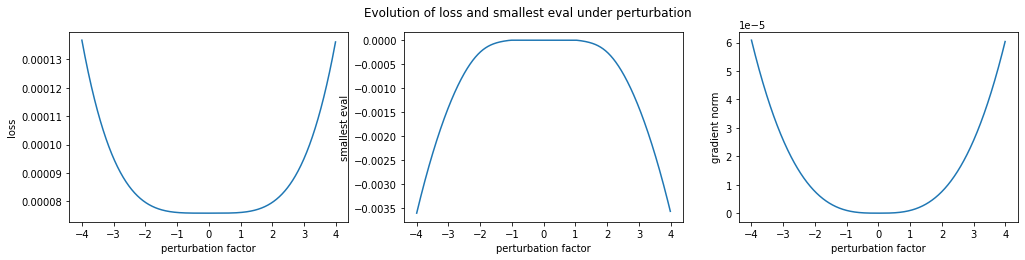

In [34]:
old_loss = loss(jnp.append(w_in.T.reshape(D_in * H_student), w_out.reshape(H_student)))

perturb_lower_bound = -4.0
perturb_upper_bound = 4.0
perturb_step = 0.01

perturb_losses = []
perturb_evals = []
perturb_grads = []

weights = jnp.append(w_in.T.reshape(D_in * H_student), w_out.reshape(H_student))
for eps in np.arange(perturb_lower_bound, perturb_upper_bound, perturb_step):
  new_weights = weights + eps * smallest_evector
  # print(new_weights[0 : D_in * H_student].reshape(D_in, H_student).T)
  # w_in = torch.DoubleTensor(new_weights[0 : D_in * H_student].reshape(D_in, H_student).T)
  # w_out = torch.DoubleTensor([new_weights[D_in * H_student:]])
  # dummy_model = DummyNetwork(D_in, H_student, D_out, w_in, w_out)
  # loss_grad = torch.autograd.grad(nn.MSELoss()(dummy_model(dataset),
  #                                              y_labels),
  #                                 dummy_model.parameters(),
  #                                 create_graph=True)
  sign = 1 if eps > 0 else -1
  perturb_grads.append(jnp.dot(grad(loss)(new_weights), sign * smallest_evector))
  
  H = hessian(loss)(new_weights)
  H = (H + H.T) / 2
  evals, _ = jnp.linalg.eig(H)

  perturb_evals.append(min(evals))
  perturb_losses.append(loss(new_weights))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(17, 3.5)
fig.suptitle('Evolution of loss and smallest eval under perturbation')

ax1.plot(np.arange(perturb_lower_bound, perturb_upper_bound, perturb_step), perturb_losses)
ax1.ticklabel_format(useOffset=False)
ax1.set_xlabel('perturbation factor')
ax1.set_ylabel('loss')

ax2.plot(np.arange(perturb_lower_bound, perturb_upper_bound, perturb_step), perturb_evals)
ax2.set_xlabel('perturbation factor')
ax2.set_ylabel('smallest eval')

ax3.plot(np.arange(perturb_lower_bound, perturb_upper_bound, perturb_step), perturb_grads)
ax3.set_xlabel('perturbation factor')
ax3.set_ylabel('gradient norm')

Check the smallest eigenvectors at perturbation factor \in {-1, 1}.

In [35]:
new_weights = weights - 0.4 * smallest_evector
H = hessian(loss)(new_weights)
H = (H + H.T) / 2
evals, evectors = jnp.linalg.eig(H)
# Sanity check
for eval in jnp.array([jax.lax.imag(eval) for eval in evals]):
  assert eval == 0

evals = jnp.array([jax.lax.real(eval) for eval in evals])
smallest_evector_left = jnp.array([jax.lax.real(elem) for elem in evectors[:, jnp.argmin(evals)]])
smallest_evector_left

DeviceArray([-2.1399963703306601e-03,  5.4972816657006393e-04,
              6.3326206204000687e-03, -1.9116188460432753e-03,
              1.8466796041539323e-03,  5.0576318994964417e-03,
             -1.3289597222773610e-04,  4.8561581604073447e-03,
             -1.6185232550214930e-03, -5.5407753288447617e-03,
              4.1321088585186327e-01, -8.1447702869298921e-01,
             -7.2114205913908977e-03,  1.4206590390472378e-03,
              4.0705695292141708e-01], dtype=float64)

In [36]:
new_weights = weights + 0.4 * smallest_evector
H = hessian(loss)(new_weights)
H = (H + H.T) / 2
evals, evectors = jnp.linalg.eig(H)
# Sanity check
for eval in jnp.array([jax.lax.imag(eval) for eval in evals]):
  assert eval == 0
print(min(evals))
evals = jnp.array([jax.lax.real(eval) for eval in evals])
print(min(evals))

smallest_evector_right = jnp.array([jax.lax.real(elem) for elem in evectors[:, jnp.argmin(evals)]])
print(min(evals))
smallest_evector_right

(1.4937008327532528e-07+0j)
1.4937008327532528e-07
1.4937008327532528e-07


DeviceArray([-2.2701649608114307e-03,  6.1056150304198700e-04,
              6.6817358057679075e-03, -2.0138242775562237e-03,
              1.9453232583187781e-03,  5.3374842952437340e-03,
             -1.4757760317406454e-04,  5.1319417031620183e-03,
             -1.7052416901839247e-03, -5.8728427938148616e-03,
              4.1348816192381771e-01, -8.1435757485357541e-01,
             -7.6149206019209166e-03,  1.4969244194340721e-03,
              4.0698746314278506e-01], dtype=float64)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'smallest eval')

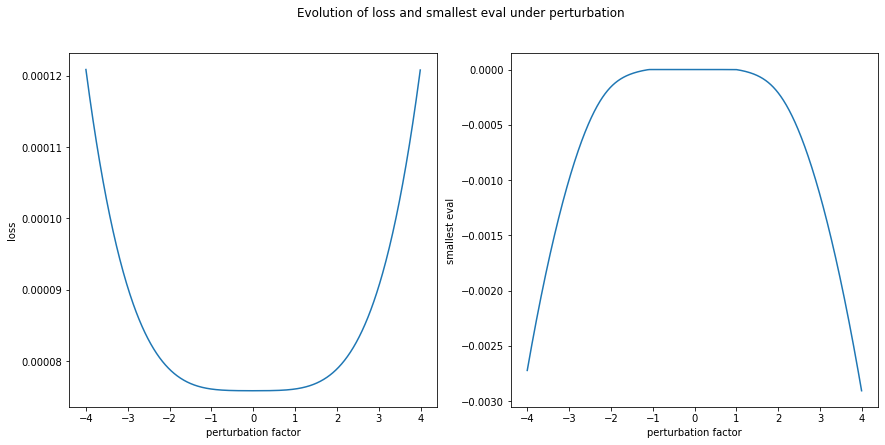

In [37]:
perturb_losses_new_smallest_evector = []
perturb_evals_new_smallest_evector = []

weights_new_smallest_evector = weights - 0.4 * smallest_evector
for eps in np.arange(perturb_lower_bound, perturb_upper_bound, perturb_step):
  new_weights = weights_new_smallest_evector + eps * smallest_evector_left
  
  H = hessian(loss)(new_weights)
  H = (H + H.T) / 2
  evals, _ = jnp.linalg.eig(H)

  perturb_evals_new_smallest_evector.append(min(evals))
  perturb_losses_new_smallest_evector.append(loss(new_weights))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(14.5, 6.5)
fig.suptitle('Evolution of loss and smallest eval under perturbation')
ax1.plot(np.arange(perturb_lower_bound, perturb_upper_bound, perturb_step), perturb_losses_new_smallest_evector)
ax1.ticklabel_format(useOffset=False)
ax1.set_xlabel('perturbation factor')
ax1.set_ylabel('loss')

ax2.plot(np.arange(perturb_lower_bound, perturb_upper_bound, perturb_step), perturb_evals_new_smallest_evector)
ax2.set_xlabel('perturbation factor')
ax2.set_ylabel('smallest eval')

In [38]:
def run_perturbation_algo():
  perturb_losses = []
  eps = 1e-10

  current_weights = weights
  perturb_losses.append(loss(current_weights))
  current_evector = smallest_evector
  # print(current_evector)
  while True:
    current_weights = current_weights + eps * current_evector
    # print(abs(jnp.dot(grad(loss)(current_weights), current_evector)))
    if abs(jnp.dot(grad(loss)(current_weights), current_evector)) >= 1e-9:
      break
    
    H = hessian(loss)(new_weights)
    H = (H + H.T) / 2
    evals, evectors = jnp.linalg.eig(H)
    evals = jnp.array([jax.lax.real(eval) for eval in evals])
    current_evector = jnp.array([jax.lax.real(elem) for elem in evectors[:, jnp.argmin(evals)]])
    perturb_losses.append(loss(current_weights))
  
  return perturb_losses

losses = run_perturbation_algo()
print(losses)
print(min(losses))

[DeviceArray(7.587703102877081e-05, dtype=float64), DeviceArray(7.587703102877038e-05, dtype=float64), DeviceArray(7.587703102877045e-05, dtype=float64), DeviceArray(7.587703102877096e-05, dtype=float64), DeviceArray(7.587703102877034e-05, dtype=float64), DeviceArray(7.587703102877173e-05, dtype=float64), DeviceArray(7.587703102877066e-05, dtype=float64), DeviceArray(7.587703102877096e-05, dtype=float64), DeviceArray(7.58770310287708e-05, dtype=float64), DeviceArray(7.587703102877053e-05, dtype=float64), DeviceArray(7.587703102877088e-05, dtype=float64), DeviceArray(7.587703102877072e-05, dtype=float64), DeviceArray(7.58770310287708e-05, dtype=float64), DeviceArray(7.58770310287705e-05, dtype=float64), DeviceArray(7.587703102877088e-05, dtype=float64), DeviceArray(7.587703102877091e-05, dtype=float64), DeviceArray(7.587703102877061e-05, dtype=float64), DeviceArray(7.587703102877074e-05, dtype=float64), DeviceArray(7.58770310287715e-05, dtype=float64), DeviceArray(7.587703102877054e-05,